# SPINE PROBLEMS

## 0 IMPORT LIBRARIES

In [1]:
import polars as pl
import os
import torch
import torch.nn as nn
from dataclasses import dataclass
from typing import Literal
import optuna
from optuna import Study, Trial
import optuna.pruners as pruners
import optuna.samplers as samplers
import optuna.storages as storages
from pathlib import Path


### 0.1 Set Device

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


### 1 GLOBAL SEATINGS

In [3]:
WORKDIR_PATH = "" # "../"
IMAGE_DIM = 256
NO_CACHE = True
CACHE_DIR = WORKDIR_PATH + ".cache/"
DATASET_DIR = WORKDIR_PATH + "dataset/"
ANOTTATIONS_DIR = DATASET_DIR + "annotations/"
TRAIN_DIR = os.path.join(DATASET_DIR, "train_images/")
LOAD_SESSION = False
REDUCTION_PERCENTAGE = 0.2
AUGMENTATION_PERCENTAGE = 0.5
RESOURCES = "resources/"

## 2 Preprocessing

### 2.2 Load Dataset

In [4]:
from utils import visualice, process_data

lazy_dataset = any
if os.path.exists(CACHE_DIR + "preprocesed_dataset.parquet"):
    print("cache")
    lazy_dataset = pl.scan_parquet(CACHE_DIR + 'preprocesed_dataset.parquet')
    LENGTH = lazy_dataset.select(pl.len()).collect().item()
    NO_CACHE = False
else:
    print("from zero")
    lazy_dataset = pl.scan_csv(ANOTTATIONS_DIR + 'train.csv')
    # lazy_dataset = pl.scan_csv(ANOTTATIONS_DIR + 'p.csv')
    LENGTH = lazy_dataset.select(pl.len()).collect().item()
LENGTH = lazy_dataset.select(pl.len()).collect().item()
print(LENGTH)

from zero
19550


In [5]:
if NO_CACHE:
    lesionTypes = lazy_dataset.select(["lesion_type"]).collect().unique().to_series().to_list()
    num_class = len(lesionTypes)
    print(lesionTypes)

['Spondylolysthesis', 'No finding', 'Other lesions', 'Foraminal stenosis', 'Surgical implant', 'Osteophytes', 'Vertebral collapse', 'Disc space narrowing']


### 2.3 Filter dataset 

In [6]:
if NO_CACHE:
    lazy_dataset = (
        lazy_dataset
        .select(['image_id', 'lesion_type'])
    )

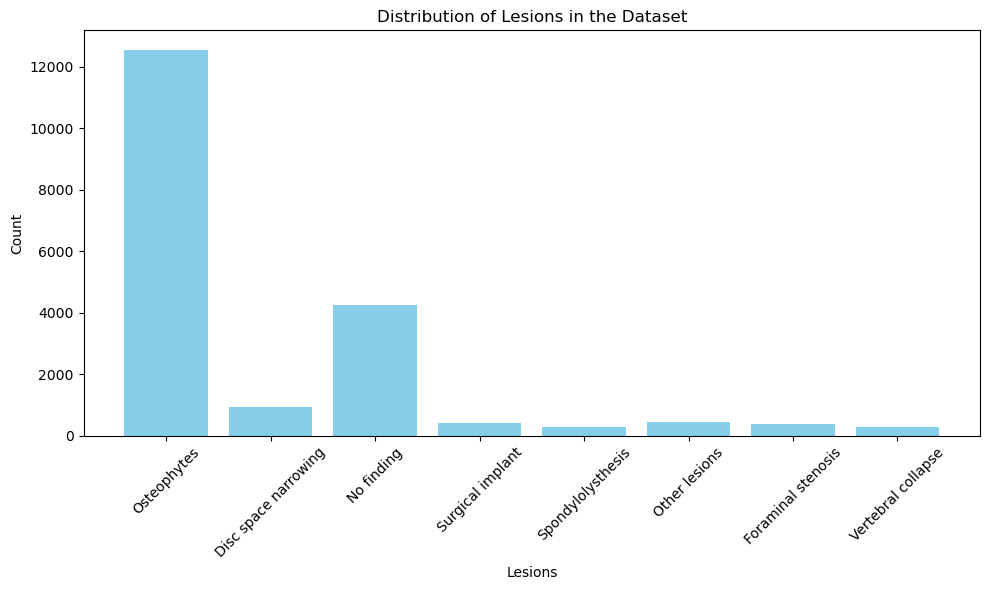

In [7]:
import matplotlib.pyplot as plt
if NO_CACHE:
    label_counts_pd = (
            lazy_dataset.
            group_by('lesion_type').agg(
        pl.count('image_id').alias('count')
        )
    )
    # Convert to pandas for easier plotting
    label_counts = label_counts_pd.collect()
    # Extract data for plotting
    labels = label_counts['lesion_type'].to_list()
    counts = label_counts['count'].to_list()

    # Plot using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Lesions')
    plt.ylabel('Count')
    plt.title('Distribution of Lesions in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

as we can see, the dataset is too invalanced. Our aprouch in this case is going to be the next one:
    1. Take the No finding and Osteophytes classes, they are the 2 most common classes
    2. Filter for duplicate values inside those two classes. Doing this we are only taking the images that have Osteophytes OR No finding
    3. See if the data is invalanced
    3. When we have the same amount of data for each values

In [8]:
if NO_CACHE:
    for lesions in lesionTypes:
        if lesions == "No finding":
            lazy_frame_to_augment = ((
                lazy_dataset
                .filter((pl.col("lesion_type") == lesions))
            ))
    for lesions in lesionTypes:
        if lesions == "Osteophytes":
            lazy_frame_to_maintein = ((
                lazy_dataset
                .filter((pl.col("lesion_type") == lesions))
            ))

In [9]:
if NO_CACHE:
    print(lazy_frame_to_augment.select(pl.len()).collect().item())
    print(lazy_frame_to_maintein.select(pl.len()).collect().item())
    visualice.visualice_lazyframe(lazy_frame_to_augment)


4260
12556


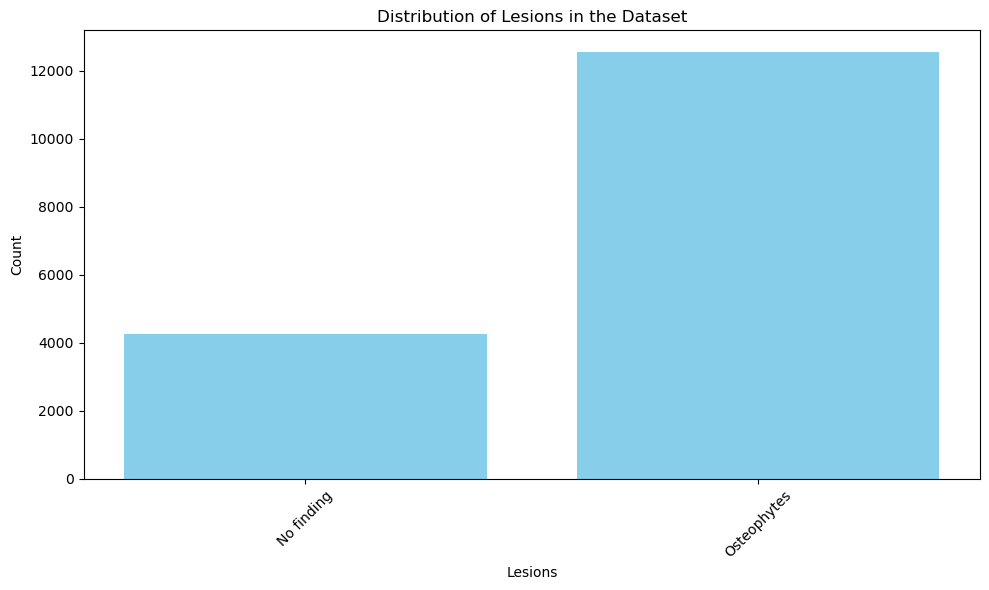

In [10]:
if NO_CACHE:
    label_counts_pd = (
            pl.concat([lazy_frame_to_augment, lazy_frame_to_maintein]).
            group_by('lesion_type').agg(
        pl.count('image_id').alias('count')
        )
    )
    # Convert to pandas for easier plotting
    label_counts = label_counts_pd.collect()
    # Extract data for plotting
    labels = label_counts['lesion_type'].to_list()
    counts = label_counts['count'].to_list()

    # Plot using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Lesions')
    plt.ylabel('Count')
    plt.title('Distribution of Lesions in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
if NO_CACHE:
    lazy_frame_to_augment = (
        lazy_frame_to_augment.group_by("image_id").agg(
        pl.col("lesion_type"))
    )
    lazy_frame_to_maintein = (
        lazy_frame_to_maintein.group_by("image_id").agg(
        pl.col("lesion_type"))
    )
    print(lazy_frame_to_maintein.select(pl.len()).collect().item())
    print(lazy_frame_to_augment.select(pl.len()).collect().item())

3575
4260


In [12]:
if NO_CACHE:
    lazy_frame_to_augment = (
        lazy_frame_to_augment
        .with_columns((pl.lit(TRAIN_DIR) + (pl.col("image_id")+pl.lit('.dicom'))).alias("image_path"))
        .drop('image_id')
    )
    lazy_frame_to_maintein = (
        lazy_frame_to_maintein
        .with_columns((pl.lit(TRAIN_DIR) + (pl.col("image_id")+pl.lit('.dicom'))).alias("image_path"))
        .drop('image_id')
    )

## 2. Data Aumentation

In [13]:
if NO_CACHE:
    lazy_frame_to_maintein = (lazy_frame_to_maintein
            .with_columns([
                pl.col('lesion_type')
                .list.unique()  # Remove duplicates within each list
                .alias('lesion_labels')
            ]).drop("lesion_type"))
    lazy_frame_to_augment = (lazy_frame_to_augment
            .with_columns([
                pl.col('lesion_type')
                .list.unique()  # Remove duplicates within each list
                .alias('lesion_labels')
            ]).drop("lesion_type"))
    visualice.visualice_lazyframe(lazy_frame_to_maintein)

In [14]:
if NO_CACHE:
    lazy_frame_to_maintein = (
        lazy_frame_to_maintein.with_columns(
            pl.format("{}",
            pl.col("lesion_labels").cast(pl.List(pl.String)).list.join("").alias("lesion"))
        ).drop("lesion_labels")
    )
    lazy_frame_to_augment = (
        lazy_frame_to_augment.with_columns(
            pl.format("{}",
            pl.col("lesion_labels").cast(pl.List(pl.String)).list.join("").alias("lesion"))
        ).drop("lesion_labels")
    )

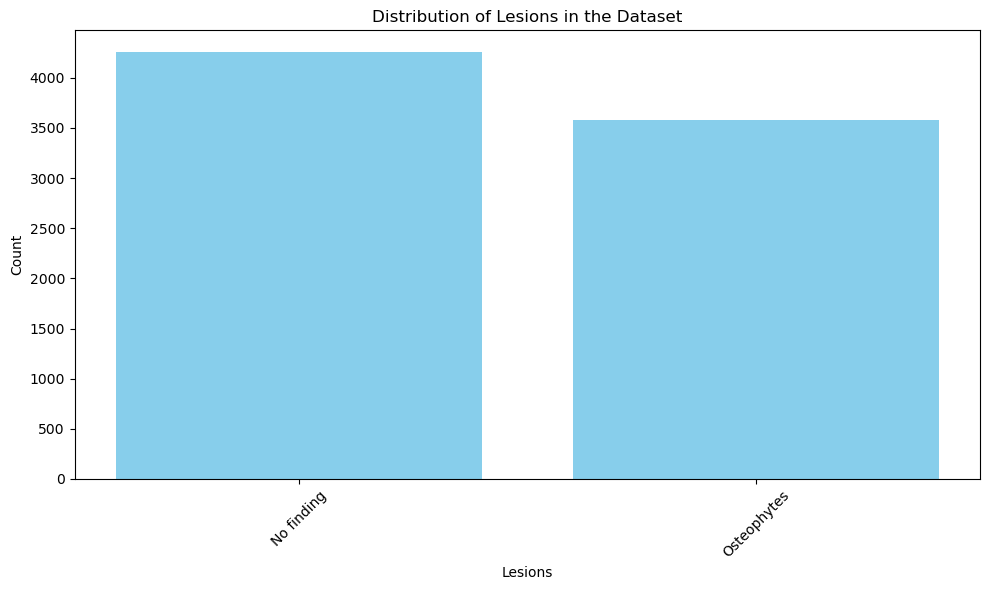

In [15]:
if NO_CACHE:
    label_counts_pd = (
            pl.concat([lazy_frame_to_augment, lazy_frame_to_maintein]).
            group_by('lesion').agg(
        pl.count('image_path').alias('count')
        )
    )
    # Convert to pandas for easier plotting
    label_counts = label_counts_pd.collect()
    # Extract data for plotting
    labels = label_counts['lesion'].to_list()
    counts = label_counts['count'].to_list()

    # Plot using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Lesions')
    plt.ylabel('Count')
    plt.title('Distribution of Lesions in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

after removing duplicates, we can see that the dataset is more balanced than before

In [16]:
if NO_CACHE:
    lazy_dataset = pl.concat([lazy_frame_to_augment, lazy_frame_to_maintein])

### AUMENTATION

In [17]:
if NO_CACHE:
    lazy_frames_aumented =[]
    lenth = int(lazy_dataset.select(pl.len()).collect().item()*AUGMENTATION_PERCENTAGE)
    lazy_frames_aumented.append(lazy_dataset)
    lazy_frames_aumented.append(
                    lazy_dataset.select(
                        pl.all().sample(n=lenth, shuffle=True)
                    )
            )

In [18]:
if NO_CACHE:
    NORMAL_LENGTH = lazy_frames_aumented[0].select(pl.len()).collect().item()
    AUGMENTED_LENGTH = lazy_frames_aumented[1].select(pl.len()).collect().item()
    print(f"Dataset: {NORMAL_LENGTH}")
    print(f"Augmented Dataset: {AUGMENTED_LENGTH}")

Dataset: 7835
Augmented Dataset: 3917


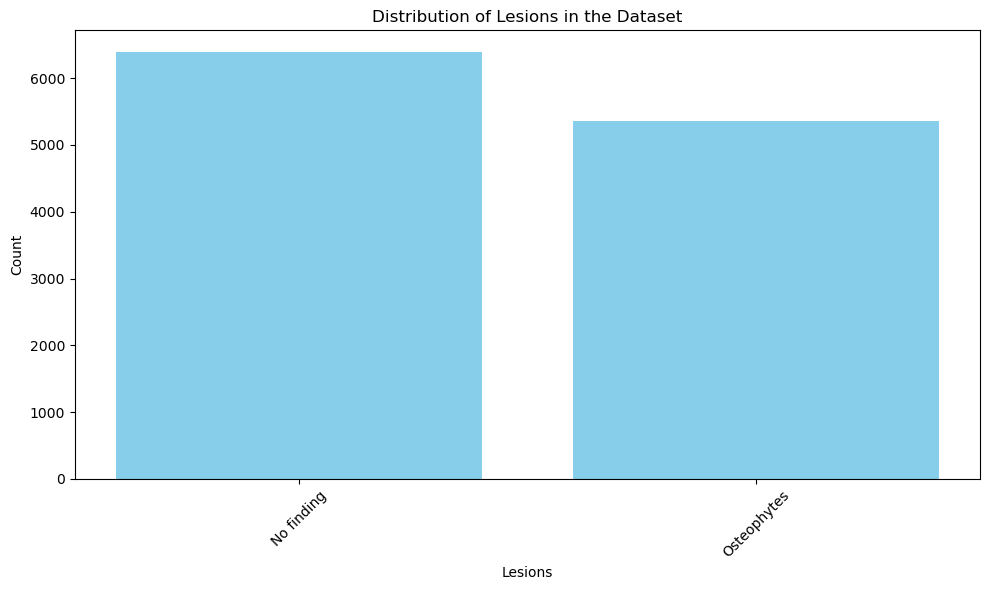

In [19]:
if NO_CACHE:
    label_counts_pd = (
            pl.concat(lazy_frames_aumented).
            group_by('lesion').agg(
        pl.count('image_path').alias('count')
        )
    )
    # Convert to pandas for easier plotting
    label_counts = label_counts_pd.collect()
    # Extract data for plotting
    labels = label_counts['lesion'].to_list()
    counts = label_counts['count'].to_list()

    # Plot using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Lesions')
    plt.ylabel('Count')
    plt.title('Distribution of Lesions in the Dataset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [20]:
from utils import load_image, create_parquet

if NO_CACHE:
    lazy_frames_aumented[0] = (lazy_frames_aumented[0]
                    .with_columns(
                        pl.col("image_path")
                        .map_elements(
                            function=process_data.preprocess,
                            return_dtype=pl.List(pl.List(pl.Float32))
                            )
                        .alias("loaded_image")
                    )
                    .drop("image_path")
            )
    lazy_frames_aumented[1] = (lazy_frames_aumented[1]
                    .with_columns(
                        pl.col("image_path")
                        .map_elements(
                            function=process_data.preprocess_and_augment,
                            return_dtype=pl.List(pl.List(pl.Float32))
                            )
                        .alias("loaded_image")
                    )
                    .drop("image_path")
            )

In [21]:
if NO_CACHE:
    create_parquet.process_lazy_images(lazy_frames_aumented[0],total_rows=NORMAL_LENGTH, chunk_size=50, output_path=CACHE_DIR, name="data.parquet")

In [22]:
if NO_CACHE:
    create_parquet.process_lazy_images(lazy_frames_aumented[1],total_rows=AUGMENTED_LENGTH, chunk_size=50, output_path=CACHE_DIR, name="augmented.parquet")

In [23]:
if NO_CACHE:
    combined_lf = pl.scan_parquet([os.path.join(CACHE_DIR,f"data.parquet"), os.path.join(CACHE_DIR,f"augmented.parquet")])

    combined_lf.sink_parquet(
        os.path.join(CACHE_DIR, "preprocesed_dataset.parquet"),
        compression="snappy",
        compression_level=22,
    )

In [24]:
if NO_CACHE:
    os.remove(os.path.join(CACHE_DIR,f"data.parquet"))
    os.remove(os.path.join(CACHE_DIR,f"augmented.parquet"))
    lazy_dataset = pl.scan_parquet([os.path.join(CACHE_DIR,f"preprocesed_dataset.parquet")])


In [25]:
LENGTH = lazy_dataset.select(pl.len()).collect().item()
print(lazy_dataset.select(pl.len()).collect().item())
visualice.visualice_lazyframe(lazy_dataset)

11752


lesion,loaded_image
str,list[list[f32]]
"""Osteophytes""","[[0.922977, 0.922718, … 0.907676], [0.922718, 0.923237, … 0.908454], … [0.091546, 0.084544, … 0.908973]]"
"""No finding""","[[0.272404, 0.26273, … 0.218997], [0.229252, 0.231128, … 0.215381], … [0.472969, 0.488457, … 0.0]]"
"""No finding""","[[0.88997, 0.892216, … 0.597555], [0.89521, 0.90494, … 0.58009], … [0.405938, 0.386477, … 0.520958]]"
"""Osteophytes""","[[0.115951, 0.238375, … 0.456151], [0.145674, 0.296056, … 0.496174], … [0.075338, 0.170689, … 0.023838]]"
"""Osteophytes""","[[0.368743, 0.762792, … 0.030033], [0.470523, 0.962736, … 0.043382], … [0.161012, 0.340378, … 0.038932]]"


In [26]:
lesionTypes = lazy_dataset.select(["lesion"]).collect().unique().to_series().to_list()
num_class = len(lesionTypes)
print(lesionTypes)

['Osteophytes', 'No finding']


In [21]:
from utils.training import trainerClass, dataloader

train_dataset, test_dataset = torch.utils.data.random_split(dataloader.LazyFrameDataset(lazy_frame=lazy_dataset, dataset_length=LENGTH), [0.8, 0.2])
print(len(test_dataset))

3910


### 2.8 Split the dataset

## 3 AUTOENCODER

### 3.1 Covolutional Block

In [28]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate:float, kernel_size:int, activation):
        super().__init__()
        padding = kernel_size // 2
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Dropout2d(dropout_rate)
        )
    def forward(self, x):
        return self.block(x)

### 3.2 Encoder

In [29]:
class Encoder(nn.Module):
    def __init__(self, in_channels:int=1, base_filters:int=64):
        super().__init__()

        self.in_channels = in_channels
        self.base_filters = base_filters

        self.pool = nn.MaxPool2d((2, 2))

        self.level1 = ConvolutionBlock(self.in_channels, self.base_filters,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.level2 = ConvolutionBlock(self.base_filters, self.base_filters * 2,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.level3 = ConvolutionBlock(self.base_filters * 2, self.base_filters * 4,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        
        self.bottleneck = ConvolutionBlock(self.base_filters * 4, self.base_filters * 8,dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
    def forward(self, x):

        skip_connections = []

        level1_features = self.level1(x)
        skip_connections.append(level1_features)
        level1_pooled = self.pool(level1_features)

        level2_features = self.level2(level1_pooled)
        skip_connections.append(level2_features)
        level2_pooled = self.pool(level2_features)

        level3_features = self.level3(level2_pooled)
        skip_connections.append(level3_features)
        level3_pooled = self.pool(level3_features)

        bottleneck_features = self.bottleneck(level3_pooled)
        return {
            'encoded_image': bottleneck_features,
            'skip_connections': skip_connections
        }

### 3.3 Decoder


In [30]:
class Decoder(nn.Module):
    def __init__(self, in_channels:int=1, base_filters:int=64):
        super().__init__()
        
        self.in_channels = in_channels
        self.base_filters = base_filters * 8
        
        self.upconv1 = nn.ConvTranspose2d(self.base_filters//1, self.base_filters // 2, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(self.base_filters // 2, self.base_filters // 4, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(self.base_filters // 4, self.base_filters // 8, kernel_size=2, stride=2)
        
        self.conv1 = ConvolutionBlock(self.base_filters, self.base_filters // 2, dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.conv2 = ConvolutionBlock(self.base_filters // 2, self.base_filters // 4, dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.conv3 = ConvolutionBlock(self.base_filters // 4, self.base_filters // 8, dropout_rate=0.2, kernel_size=3, activation=nn.ReLU())
        self.output_conv = nn.Conv2d(self.base_filters // 8, in_channels, kernel_size=1)
        
    def forward(self, encoder_output):

        features = encoder_output['encoded_image']
        skip_connections = encoder_output['skip_connections']
        up1 = self.upconv1(features)
        up1 = torch.cat([up1, skip_connections[2]], dim=1)
        up1 = self.conv1(up1)

        up2 = self.upconv2(up1)
        up2 = torch.cat([up2, skip_connections[1]], dim=1)
        up2 = self.conv2(up2)

        up3 = self.upconv3(up2)
        up3 = torch.cat([up3, skip_connections[0]], dim=1)
        up3 = self.conv3(up3)

        output = torch.sigmoid(self.output_conv(up3))
        return {"recontruction":output, "encoded_image":encoder_output['encoded_image']}

### 3.4 Autoencoder

In [31]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.encoder.to(device)
        
        self.decoder = decoder
        self.decoder.to(device)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 3.5 Classifier

In [32]:
class Classifier(nn.Module):
    def __init__(self, num_classes, encoder):
        super().__init__()
        self.encoder = encoder
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Define classifier with explicit num_classes output
        self.classifier = nn.Sequential(
            nn.Flatten(),  # Will flatten 512x1x1 to 512
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)  # This should now correctly output num_classes
        )
        
    def forward(self, x):
        encoder_output = self.encoder(x)
        encoded_features = encoder_output['encoded_image']
        pooled_features = self.global_pool(encoded_features)
        logits = self.classifier(pooled_features)
        return logits

## 4 Model

#### 4.1 Hyperparameter Tuner

In [33]:
from utils.training import trainerClass, dataloader
from utils.training.checkpoint import ModelCheckpointer

@dataclass
class HyperparameterTuner:
    gc_after_trial: bool
    n_jobs: int
    n_trials: int
    timeout: float | None
    tuning_direction: Literal["minimize", "maximize"]
    train_epochs: int | None
    show_progress_bar: bool
    study_load_if_exists: bool
    study_name: str
    study_pruner: optuna.pruners.BasePruner
    study_sampler: optuna.samplers.BaseSampler
    # study_storage: optuna.storages.BaseStorage
    
    compute_device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    def objective(self, trial: Trial) -> float:
        encoder = Encoder()
        trainer = trainerClass.Trainer(autoencoder=Autoencoder(encoder, Decoder()), checkpointer=ModelCheckpointer(save_path=Path(f"checkpoint/trial_{trial.number}_checkpoint.pt")),classifier=Classifier(num_class, encoder),training_set=test_dataset, batch_size=3, device=device, patience=7, n_folds=3)
        trainer.train(trial=trial, num_epochs=self.train_epochs)

        trial.set_user_attr("checkpoint_path", f"checkpoint/trial_{trial.number}_checkpoint.pt")
        # Free resources
        trainer.free()

        # Get the best loss achieved
        best_loss = min(loss_dict for loss_dict in trainer.fnr_history)

        return best_loss
    def tune(self) -> Study:
        """
        Execute the hyperparameter optimization study.

        Creates or loads an Optuna study and runs the optimization process
        according to the configured parameters.

        Returns
        -------
        Study
            The completed Optuna study containing trial results and statistics.

        Notes
        -----
        The optimization process can be customized through the class parameters:
        - Number of trials and parallel jobs.
        - Time limit.
        - Progress bar visibility.
        - Garbage collection behavior.
        - Study persistence and loading.
        """
        study = optuna.create_study(
            # storage=self.study_storage,
            sampler=self.study_sampler,
            pruner=self.study_pruner,
            study_name=self.study_name,
            direction=self.tuning_direction,
            load_if_exists=self.study_load_if_exists,
        )

        study.optimize(
            func=self.objective,
            n_trials=self.n_trials,
            timeout=self.timeout,
            n_jobs=self.n_jobs,
            catch=(),
            callbacks=(),
            gc_after_trial=self.gc_after_trial,
            show_progress_bar=self.show_progress_bar,
        )

        return study

### 4.2 Tuner

In [34]:
tuner = HyperparameterTuner(
    gc_after_trial=True,
    n_jobs=1,
    n_trials=50,
    timeout=None,
    tuning_direction="minimize",
    train_epochs=50,
    show_progress_bar=True,
    study_load_if_exists=True,
    study_name="backAnalizer",
    study_pruner=pruners.MedianPruner(),
    study_sampler=samplers.TPESampler(),

)

study = tuner.tune()

[I 2025-01-22 12:33:24,136] A new study created in memory with name: backAnalizer


  0%|          | 0/5 [00:00<?, ?it/s]


Fold 1/2


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/1], Fold [1/2]
Train - Total Loss: 0.7391, FNR: 0.4000
Best model save!
0.8333333333333334 0.0 True

Fold 2/2


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/1], Fold [2/2]
Train - Total Loss: 0.7414, FNR: 0.5000
Best model save!


/home/unai/anaconda3/envs/ia/lib/python3.11/site-packages/optuna/trial/_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(


0.8166666666666667 0.016666666666666663 True
[W 2025-01-22 12:37:21,900] Trial 0 failed with parameters: {} because of the following error: TypeError('list indices must be integers or slices, not str').
Traceback (most recent call last):
  File "/home/unai/anaconda3/envs/ia/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_614881/3366827865.py", line 30, in objective
    best_loss = min(loss_dict["val"]["fnr"] for loss_dict in trainer.fnr_history)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_614881/3366827865.py", line 30, in <genexpr>
    best_loss = min(loss_dict["val"]["fnr"] for loss_dict in trainer.fnr_history)
                    ~~~~~~~~~^^^^^^^
TypeError: list indices must be integers or slices, not str
[W 2025-01-22 12:37:21,902] Trial 0 failed with value None.


TypeError: list indices must be integers or slices, not str

In [35]:
print(
    f"Best Trial: Trial {study.best_trial.number}\n"
    f"\tLoss Value: {study.best_trial.value}\n"
)

ValueError: No trials are completed yet.

In [38]:
from utils.training.checkpoint import ModelCheckpointer
from pathlib import Path

checkpoint = (
    ModelCheckpointer
        .load_best_checkpoint(
            Path(
               study
                    .best_trial
                    .user_attrs["checkpoint_path"]
            )
        )
)

Running on the CPU


In [39]:
print(checkpoint)


{'model_state': OrderedDict([('encoder.level1.block.0.weight', tensor([[[[-0.1747,  0.1921,  0.2801],
          [ 0.1872, -0.2173, -0.1401],
          [ 0.2729, -0.1120, -0.1274]]],


        [[[-0.0289, -0.1975,  0.2572],
          [-0.1607, -0.1308, -0.0797],
          [ 0.0898,  0.0854, -0.0494]]],


        [[[-0.1279, -0.0838, -0.3337],
          [-0.3172, -0.3239,  0.2731],
          [ 0.1318,  0.2091,  0.1687]]],


        [[[ 0.1435,  0.2173,  0.1063],
          [ 0.3371, -0.1860, -0.2497],
          [-0.0342,  0.0840, -0.0778]]],


        [[[-0.2847,  0.1095, -0.3272],
          [-0.0660, -0.2894, -0.3247],
          [-0.3216, -0.1409, -0.0152]]],


        [[[ 0.1810, -0.2850, -0.0378],
          [-0.2980,  0.2458, -0.0619],
          [-0.2910,  0.1072, -0.1622]]],


        [[[-0.1574,  0.1114, -0.2579],
          [-0.1139, -0.1661, -0.1041],
          [ 0.1009, -0.0794,  0.0685]]],


        [[[ 0.1373,  0.1095, -0.0765],
          [-0.2315,  0.2188,  0.0856],
          [ 